In [1]:
import os
import six
import glob
import pickle

import numpy as np
import pandas as pd

import p2pspatial
import pulse2percept.utils as p2pu

from sklearn.base import clone

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

/home/mbeyeler/anaconda3/lib/python3.5/site-packages/skvideo/__init__.py:356: UserWarning: avconv/avprobe not found in path: 
  warnings.warn("avconv/avprobe not found in path: " + str(path), UserWarning)
2018-04-01 20:41:37,009 [pulse2percept] [INFO] Welcome to pulse2percept


In [2]:
results_dir = '../../results/shapefit/'
pickle_files = np.sort(glob.glob(os.path.join(results_dir, '*.pickle')))
pickle_files

array([ '../../results/shapefit/12-005-A-shapefit-swarm_2018-04-01_19-29-01.pickle',
       '../../results/shapefit/52-001-A-shapefit-swarm_2018-04-01_19-32-20.pickle',
       '../../results/shapefit/TB-A-shapefit-swarm_2018-04-01_19-30-51.pickle'], 
      dtype='<U73')

In [3]:
subjects = ['12-005', '51-009', '52-001', 'TB']
models = ['A', 'C', 'D2', 'E2', 'F2']
assert_params = {
    'amplitude': 2.0,
}
rootfolder = os.path.join(os.environ['SECOND_SIGHT_DATA'], 'shape')

In [4]:
drawing = {
    'TB': {
        'major': (1/1.34, 1/0.939),
        'minor': (1/1.19, 1/1.62),
        'orient': -9
    },
    '12-005': {
        'major': (1/0.632, 1/0.686),
        'minor': (1/0.704, 1/1.35),
        'orient': -16
    },
    '51-009': {
        'major': (1/1.38, 1/1.34),
        'minor': (1/1.06, 1/1.94),
        'orient': 4
    },
    '52-001': {
        'major': (1/1.39, 1/1.47),
        'minor': (1/1.76, 1/1.61),
        'orient': -14
    }
}

In [5]:
def periodic_corr(alpha1, alpha2, nanrobust=False, axis=None):
    # https://github.com/jhamrick/python-snippets/blob/master/snippets/circstats.py
    if axis is not None and alpha1.shape[axis] != alpha2.shape[axis]:
        raise(ValueError, "shape mismatch")

    # compute mean directions
    if axis is None:
        n = alpha1.size
    else:
        n = alpha1.shape[axis]

    c1 = np.cos(alpha1)
    c1_2 = np.cos(2*alpha1)
    c2 = np.cos(alpha2)
    c2_2 = np.cos(2*alpha2)
    s1 = np.sin(alpha1)
    s1_2 = np.sin(2*alpha1)
    s2 = np.sin(alpha2)
    s2_2 = np.sin(2*alpha2)

    if nanrobust:
        sumfunc = lambda x: np.nansum(x, axis=axis)
    else:
        sumfunc = lambda x: np.sum(x, axis=axis)

    num = 4 * (sumfunc(c1*c2) * sumfunc(s1*s2) -
               sumfunc(c1*s2) * sumfunc(s1*c2))
    den = np.sqrt((n**2 - sumfunc(c1_2)**2 - sumfunc(s1_2)**2) *
                  (n**2 - sumfunc(c2_2)**2 - sumfunc(s2_2)**2))

    rho = num / den

    return rho

In [6]:
import sklearn.metrics as sklm

12-005 A corrloss=3.506763 r2loss=10.685781
52-001 A corrloss=3.610835 r2loss=11.341914
TB A corrloss=3.689243 r2loss=60.391938


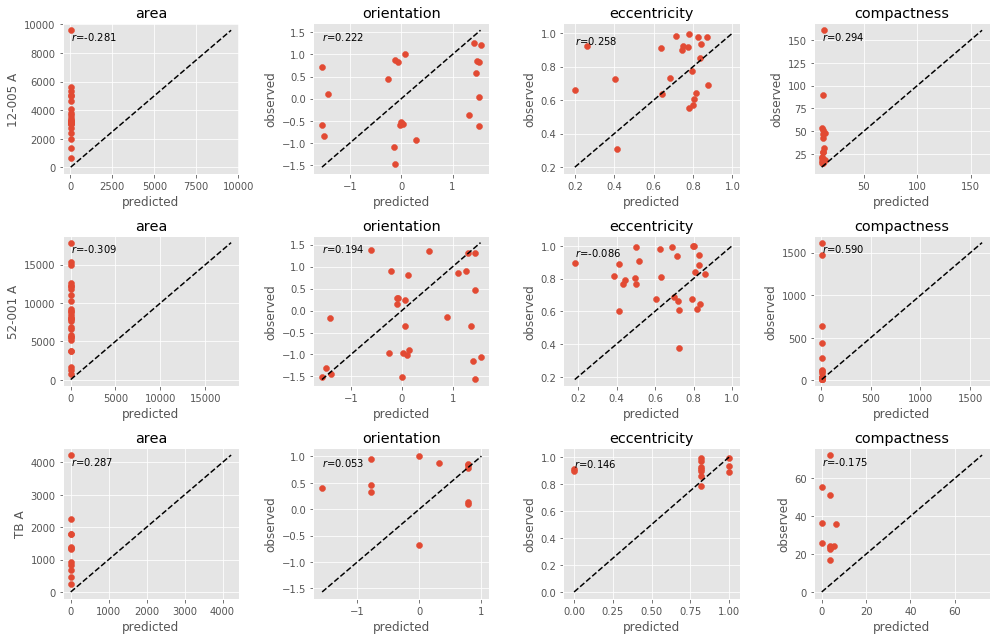

In [7]:
columns = ['area', 'orientation', 'eccentricity', 'compactness']
fig, axes = plt.subplots(ncols=len(columns), nrows=len(pickle_files), figsize=(14, 3 * len(pickle_files)))
for pickle_file, axrow in zip(pickle_files, axes):
    y, y_pred, best_params, specifics = pickle.load(open(pickle_file, 'rb'))
    corrloss = 0
    r2loss = 0
    for col, ax in zip(columns, axrow):
        if col == 'orientation':
            corr = periodic_corr(y[col], y_pred[col])
        else:
            corr = y[col].corr(y_pred[col])
        r2 = sklm.r2_score(y[col], np.nan_to_num(y_pred[col]))
        ax.scatter(y_pred[col], y[col])
        minval = np.minimum(y[col].min(), y_pred[col].min())
        maxval = np.maximum(y[col].max(), y_pred[col].max())
        ax.plot([minval, maxval], [minval, maxval], 'k--')
        ax.set_title(col)
        ax.set_xlabel('predicted')
        ax.set_ylabel('observed')
        ax.text(minval, maxval, "$r$=%.3f" % corr, va='top')
        corrloss += np.nansum([1, -corr])
        r2loss += 1 - r2
    print('%s %s corrloss=%f r2loss=%f' % (specifics['subject'], specifics['modelname'], corrloss, r2loss))
    axrow[0].set_ylabel('%s %s' % (specifics['subject'], specifics['modelname']))
fig.tight_layout()